In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import math
from scipy.stats import norm
from scipy.optimize import brentq
import string
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec

In [3]:
keep_phenotypes =  list(pd.read_table("/u/home/j/jzou1115/project-zarlab/CFW/ResultsTables/PhenotypeSummary_keep_final.csv", sep=",")["id"])

# OX1 and OX2 replication
 - load data from OX1 and OX2 splits to empirical distribution of difference in prediction

In [68]:
files = glob.glob("/u/home/j/jzou1115/project-zarlab/CFW/replication_pruned/output_ox1_ox2/*txt")
print(len(files))

100


In [69]:
def parseModel(f):
    d = open(f, "r")
    lines = d.readlines()
    d.close()
    
    true = float(lines[0])
    wc = float(lines[1])
    wcc = float(lines[2])
    var_g = float(lines[3])
    var_c1 = float(lines[4])
    var_c2 = float(lines[5])
    
    return true, wc, wcc, var_g, var_c1, var_c2

In [70]:
rep = {}
rep["file"] = []
rep["rep_true"] = []
rep["rep_wc"] = []
rep["rep_wcc"] = []
rep["var_g"] = []
rep["var_c1"] = []
rep["var_c2"] = []

for f in files:
    rep["file"].append(f)
    true, wc, wcc, var_g, var_c1, var_c2 = parseModel(f)
    rep["rep_true"].append(true)
    rep["rep_wc"].append(wc)
    rep["rep_wcc"].append(wcc)
    rep["var_g"].append(var_g)
    rep["var_c1"].append(var_c1)
    rep["var_c2"].append(var_c2)

In [71]:
rep = pd.DataFrame(rep)
rep.head()

,file,rep_true,rep_wc,rep_wcc,var_g,var_c1,var_c2
0,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.803922,0.680039,0.598196,0.0096,1.811509e-03,1.000000e-28
1,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.862745,0.714378,0.714378,8.2800,1.000000e-28,1.000000e-28
2,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.882353,0.684353,0.682242,7.5800,1.000000e-28,1.000000e-04
3,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.784314,0.669483,0.667614,0.0097,2.855592e-05,1.000000e-28
4,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.784314,0.725064,0.725064,8.8400,1.000000e-28,1.000000e-28


In [72]:
rep = rep.sort_values(by="var_c1", ascending=False)

In [73]:
def wc(var_g, n1, n2):
    slope_noConfounding = (math.sqrt(n1*n2)*var_g)/(1+n1*var_g)
    sd_noConfounding = math.sqrt(n2*var_g+1-((n1*n2*var_g*var_g)/(n1*var_g+1)))
    return slope_noConfounding, sd_noConfounding

def wcc(var_g, var_c1, var_c2, n1, n2):
    slope = (math.sqrt(n1*n2)*var_g)/(1+n1*var_g+n1*var_c1)
    sd = math.sqrt(n2*var_g+n2*var_c2+1-((n1*n2*var_g*var_g)/(n1*var_g+n1*var_c1+1)))
    return slope, sd

In [74]:
n1 = 1036
n2 = 1037

In [75]:
slope_wc = []
sd_wc = []
slope_wcc=[]
sd_wcc=[]
for i in rep.index:
    var_g = rep.loc[i, "var_g"]
    var_c1 = rep.loc[i, "var_c1"]
    var_c2 = rep.loc[i, "var_c2"]
    slope_noConfounding, sd_noConfounding = wc(var_g, n1, n2)
    slope, sd = wcc(var_g, var_c1, var_c2, n1, n2)
    slope_wc.append(slope_noConfounding)
    sd_wc.append(sd_noConfounding)
    slope_wcc.append(slope)
    sd_wcc.append(sd)
rep["slope_wc"] = slope_wc
rep["sd_wc"] = sd_wc
rep["slope_wcc"] = slope_wcc
rep["sd_wcc"] = sd_wcc


In [76]:
rep["diff"] = rep["slope_wc"] - rep["slope_wcc"]

In [77]:
def computeVarExpWCC(var_g, var_c1, n1):
    return (n1*var_c1)/ (1+n1*var_g+n1*var_c1)


In [78]:
exp_c1 = [] # variance explained by confounding
for i in rep.index:
    var_g = rep.loc[i, "var_g"]
    var_c1 = rep.loc[i, "var_c1"]
    exp_c1.append(computeVarExpWCC(var_g, var_c1, n1))
rep["exp_c1"] = exp_c1
rep["exp_c1"].describe()

count    1.000000e+02
mean     2.778252e-02
std      4.213786e-02
min      1.114707e-29
25%      1.181557e-29
50%      1.345840e-29
75%      4.579514e-02
max      1.603813e-01
Name: exp_c1, dtype: float64

In [79]:
rep["diff_pred"] = rep["rep_true"] - rep["rep_wc"]

In [80]:
rep["diff_pred_wcc"] = rep["rep_true"] - rep["rep_wcc"]

# ox vs uc

In [50]:
files = glob.glob("/u/home/j/jzou1115/project-zarlab/CFW/replication_pruned/output_phenotypes_pooled_2/*_ox_uc_sub_model_out_truncatedGaussian.txt")
print(len(files))

9


In [51]:
ox_uc = {}
ox_uc["file"] = []
ox_uc["rep_true"] = []
ox_uc["rep_wc"] = []
ox_uc["rep_wcc"] = []
ox_uc["var_g"] = []
ox_uc["var_c1"] = []
ox_uc["var_c2"] = []

for f in files:
    ox_uc["file"].append(f)
    true, wc, wcc, var_g, var_c1, var_c2 = parseModel(f)
    ox_uc["rep_true"].append(true)
    ox_uc["rep_wc"].append(wc)
    ox_uc["rep_wcc"].append(wcc)
    ox_uc["var_g"].append(var_g)
    ox_uc["var_c1"].append(var_c1)
    ox_uc["var_c2"].append(var_c2)
    


In [52]:
ox_uc = pd.DataFrame(ox_uc)
phenotypes = [f.split("/")[-1].split("_")[0] for f in ox_uc["file"]]
ox_uc["phenotype"] = phenotypes
ox_uc.head()


,file,rep_true,rep_wc,rep_wcc,var_g,var_c1,var_c2,phenotype
0,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.666667,0.920016,0.653755,0.0102,4.077899e-03,1.000000e-28,TA
1,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.666667,0.950631,0.572215,0.0093,1.158974e-02,1.000000e-28,soleus
2,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.500000,0.870381,0.461439,0.0053,7.123581e-03,1.000000e-28,gastroc
3,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,1.000000,0.916228,0.916228,22.9100,1.000000e-28,1.000000e-28,EDL
4,/u/home/j/jzou1115/project-zarlab/CFW/replicat...,0.500000,0.942070,0.719341,0.0200,8.112078e-03,1.000000e-28,bmd


In [53]:
meta = pd.read_table("/u/home/j/jzou1115/project-zarlab/CFW/ResultsTables/PhenotypeSummary_keep_final.csv", sep=",")
meta.index = meta["id"]
meta.head()

,Phenotype name,Category,Description,OX,UC,id,Category2
id,,,,,,,
tail.length,tail length,morphology,Tail length (cm),1549,1053,tail.length,morphology
habit.ratio,startle habituation ratio,prepulse inhibition,Habituation (calculated as ratio of reduction ...,1682,824,habit.ratio,behavior
habit.diff,startle habituation difference,prepulse inhibition,Habituation (calculated as difference first to...,1703,983,habit.diff,behavior
startle,startle,prepulse inhibition,Startle,1706,962,startle,behavior
pp6.ppi,PPI with +6db prepulse,prepulse inhibition,PPI with +6db prepulse,1720,936,pp6.ppi,behavior


In [54]:
ox_uc = ox_uc[ox_uc["phenotype"].isin(meta["id"])]

In [55]:
ox_n = []
uc_n = []
for i in ox_uc.index:
    p = ox_uc.loc[i, "phenotype"]
    n1 = meta.loc[p, "OX"]
    n2 = meta.loc[p, "UC"]
    ox_n.append(n1)
    uc_n.append(n2)
ox_uc["n1"] = ox_n
ox_uc["n2"] = uc_n

In [56]:
col = meta.columns[0]
phenotype2 = []
for i in ox_uc.index:
    p = ox_uc.loc[i, "phenotype"]
    p2 = meta.loc[p, col]
    phenotype2.append(p2)
ox_uc["phenotype2"] = phenotype2

In [57]:
# compute difference in true and explained replication in OX vs UC models
def wc(var_g, n1, n2):
    slope_noConfounding = (math.sqrt(n1*n2)*var_g)/(1+n1*var_g)
    sd_noConfounding = math.sqrt(n2*var_g+1-((n1*n2*var_g*var_g)/(n1*var_g+1)))
    return slope_noConfounding, sd_noConfounding

def wcc(var_g, var_c1, var_c2, n1, n2):
    slope = (math.sqrt(n1*n2)*var_g)/(1+n1*var_g+n1*var_c1)
    sd = math.sqrt(n2*var_g+n2*var_c2+1-((n1*n2*var_g*var_g)/(n1*var_g+n1*var_c1+1)))
    return slope, sd

slope_wc = []
sd_wc = []
slope_wcc=[]
sd_wcc=[]
for i in ox_uc.index:
    var_g = ox_uc.loc[i, "var_g"]
    var_c1 = ox_uc.loc[i, "var_c1"]
    var_c2 = ox_uc.loc[i, "var_c2"]
    n1 = ox_uc.loc[i, "n1"]
    n2 = ox_uc.loc[i, "n2"]
    
    slope_noConfounding, sd_noConfounding = wc(var_g, n1, n2)
    slope, sd = wcc(var_g, var_c1, var_c2, n1, n2)
    slope_wc.append(slope_noConfounding)
    sd_wc.append(sd_noConfounding)
    slope_wcc.append(slope)
    sd_wcc.append(sd)

ox_uc["slope_wc"] = slope_wc
ox_uc["sd_wc"] = sd_wc
ox_uc["slope_wcc"] = slope_wcc
ox_uc["sd_wcc"] = sd_wcc

ox_uc["diff"] = ox_uc["slope_wc"] - ox_uc["slope_wcc"]

In [58]:
def computePval(diff, null):
    count = 0
    for p in null:
        if p > diff:
            count += 1
    return count*1.0/len(null)

In [59]:
diff_pval = []
for i in ox_uc.index:
    diff = ox_uc.loc[i, "diff"]
    p = computePval(diff, rep["diff"])
    diff_pval.append(p)
ox_uc["diff_pval"] = diff_pval

In [60]:

exp_c1 = [] # variance explained by confounding
for i in ox_uc.index:
    var_g = ox_uc.loc[i, "var_g"]
    var_c1 = ox_uc.loc[i, "var_c1"]
    n1 = ox_uc.loc[i, "n1"]
    n2 = ox_uc.loc[i, "n2"]
    exp_c1.append(computeVarExpWCC(var_g, var_c1, n1))
ox_uc["exp_c1"] = exp_c1
ox_uc["exp_c1"].describe()

count    9.000000e+00
mean     3.638129e-01
std      1.939194e-01
min      4.364802e-30
25%      2.750701e-01
50%      3.458203e-01
75%      5.406774e-01
max      5.922671e-01
Name: exp_c1, dtype: float64

In [61]:
ox_uc["diff_pred"] = ox_uc["rep_true"] - ox_uc["rep_wc"]
ox_uc["diff_pred"].describe()

count    9.000000
mean    -0.278540
std      0.157228
min     -0.442070
25%     -0.370381
50%     -0.283964
75%     -0.243398
max      0.083772
Name: diff_pred, dtype: float64

In [62]:
ox_uc_pheno = ox_uc
ox_uc_pheno["diff_pred_wcc"] = ox_uc_pheno["rep_true"] - ox_uc_pheno["rep_wcc"]

In [63]:
sorter=["EDL", "tibia", "TA", "BMD", "total locomotor activity", "locomotor activity initial", "soleus", "gastroc", "locomotor activity end"]
sorterIndex = dict(zip(sorter, range(len(sorter))))
ox_uc_pheno['Pheno_Rank'] = ox_uc_pheno['phenotype2'].map(sorterIndex)

In [83]:
ox_uc_pheno = ox_uc_pheno.sort_values(['Pheno_Rank'],
        ascending = True)
ox_uc_pheno = ox_uc_pheno.sort_values(by="diff_pred")

sd = np.std(rep["diff_pred"]) #empirical distribution from OX1 vs OX2 splits

In [88]:
#data from replication power simulations

out = pd.read_table("/u/home/j/jzou1115/project-zarlab/CFW/replication_simulations/summary/replication_summary_simulations.txt")
out = out[out["sample_size"]<=2000]
power = []
threshold = 5.787229 #OX logp threshold
p = 10**-threshold
c = abs(norm.ppf(p/2)) #statistic threshold
for i in out.index:
    l = out.loc[i, "effect_size"]
    n = out.loc[i, "sample_size"]
    
    po = 1 - norm.cdf(c, loc = l*np.sqrt(n), scale = 1)
    power.append(po)

out["power"] = power

table2 = pd.pivot_table(out, values='power', index=['effect_size'],
                    columns=['sample_size'], aggfunc=np.sum)
table = pd.pivot_table(out, values='diff', index=['effect_size'],
                    columns=['sample_size'], aggfunc=np.sum)

effect_sizes = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
sample_sizes = [1000, 1500, 2000]
outdir="/u/home/j/jzou1115/project-zarlab/CFW/replication_simulations/wcrep_out/"
data = {}
data["effect_size"] = []
data["sample_size"] = []
data["observed"] = []
data["expected"] = []

for l in effect_sizes:
    for n in sample_sizes:
        f = os.path.join(outdir, "sim_"+ str(n)+ "_"+ str(l)+ ".txt")
        d = pd.read_table(f, header=None)
        data["effect_size"].append(l)
        data["sample_size"].append(n)
        data["observed"].append(d.loc[0, 0])
        data["expected"].append(d.loc[1, 0])
data = pd.DataFrame(data)
data["diff"] = data["observed"] - data["expected"]
table3 = pd.pivot_table(data, values='diff', index=['effect_size'],
                    columns=['sample_size'], aggfunc=np.sum)
table3 = table.round(2)
power = []
for i in data.index:
    l = data.loc[i, "effect_size"]
    n = data.loc[i, "sample_size"]
    
    po = 1 - norm.cdf(c, loc = l*np.sqrt(n), scale = 1)
    power.append(po)
data["power"] = power


In [89]:
# variance explained in OX vs UC models
keep_phenotypes =  list(pd.read_table("/u/home/j/jzou1115/project-zarlab/CFW/ResultsTables/PhenotypeSummary_keep_final.csv", sep=",")["id"])
def parseModel(f):
    d = open(f, "r")
    lines = d.readlines()
    d.close()
    
    true = float(lines[0])
    wc = float(lines[1])
    wcc = float(lines[2])
    var_g = float(lines[3])
    var_c1 = float(lines[4])
    var_c2 = float(lines[5])
    var_s1 = float(lines[6])
    
    return true, wc, wcc, var_g, var_c1, var_c2, var_s1
files = glob.glob("/u/home/j/jzou1115/project-zarlab/CFW/replication_pruned/output_phenotypes_pooled_2/*_ox_uc_sub_model_out_truncatedGaussian.txt")
#files = glob.glob("/u/home/j/jzou1115/project-zarlab/CFW/replication_pruned/output_phenotypes_pooled_2/*_ox_uc_sub_model_out.txt")
print(len(files))

rep = {}
rep["file"] = []
rep["rep_true"] = []
rep["rep_wc"] = []
rep["rep_wcc"] = []
rep["var_g"] = []
rep["var_c1"] = []
rep["var_c2"] = []
rep["var_s1"] = []

for f in files:
    rep["file"].append(f)
    true, wc, wcc, var_g, var_c1, var_c2, var_s1 = parseModel(f)
    rep["rep_true"].append(true)
    rep["rep_wc"].append(wc)
    rep["rep_wcc"].append(wcc)
    rep["var_g"].append(var_g)
    rep["var_c1"].append(var_c1)
    rep["var_c2"].append(var_c2)
    rep["var_s1"].append(var_s1)
    
rep = pd.DataFrame(rep)
rep.head()
rep["phenotype"] = [ rep.loc[i, "file"].split("/")[-1].split("_")[0] for i in rep.index]
rep = rep[rep["phenotype"].isin(keep_phenotypes)]
meta = pd.read_table("/u/home/j/jzou1115/project-zarlab/CFW/ResultsTables/PhenotypeSummary_keep_final.csv", sep=",")
meta.index = meta["id"]
meta.head()
ox_n = []
uc_n = []
for i in rep.index:
    p = rep.loc[i, "phenotype"]
    n1 = meta.loc[p, "OX"]
    n2 = meta.loc[p, "UC"]
    ox_n.append(n1)
    uc_n.append(n2)
rep["n1"] = ox_n
rep["n2"] = uc_n
col = meta.columns[0]
phenotype2 = []
for i in rep.index:
    p = rep.loc[i, "phenotype"]
    p2 = meta.loc[p, col]
    phenotype2.append(p2)
rep["phenotype2"] = phenotype2
rep["var_exp_c1"] = rep["var_c1"]*rep["n1"] / rep["var_s1"]
rep["var_exp_g"] =  (rep["var_s1"] - 1 - rep["var_c1"]*rep["n1"] ) / rep["var_s1"]
rep = rep.sort_values(by="var_exp_c1")
plot_data = {}
plot_data["phenotype2"] = []
plot_data["var_exp"] = []
plot_data["Variance Explained"] = []

for i in rep.index:
    p = rep.loc[i, "phenotype2"]
    v_c1 = rep.loc[i, "var_exp_c1"]
    v_g = rep.loc[i, "var_exp_g"] 
    plot_data["phenotype2"].append(p)
    plot_data["var_exp"].append(v_c1)
    plot_data["Variance Explained"].append("Confounding")
    
    plot_data["phenotype2"].append(p)
    plot_data["var_exp"].append(v_g)
    plot_data["Variance Explained"].append("Genetics")
    
plot_data = pd.DataFrame(plot_data)


9


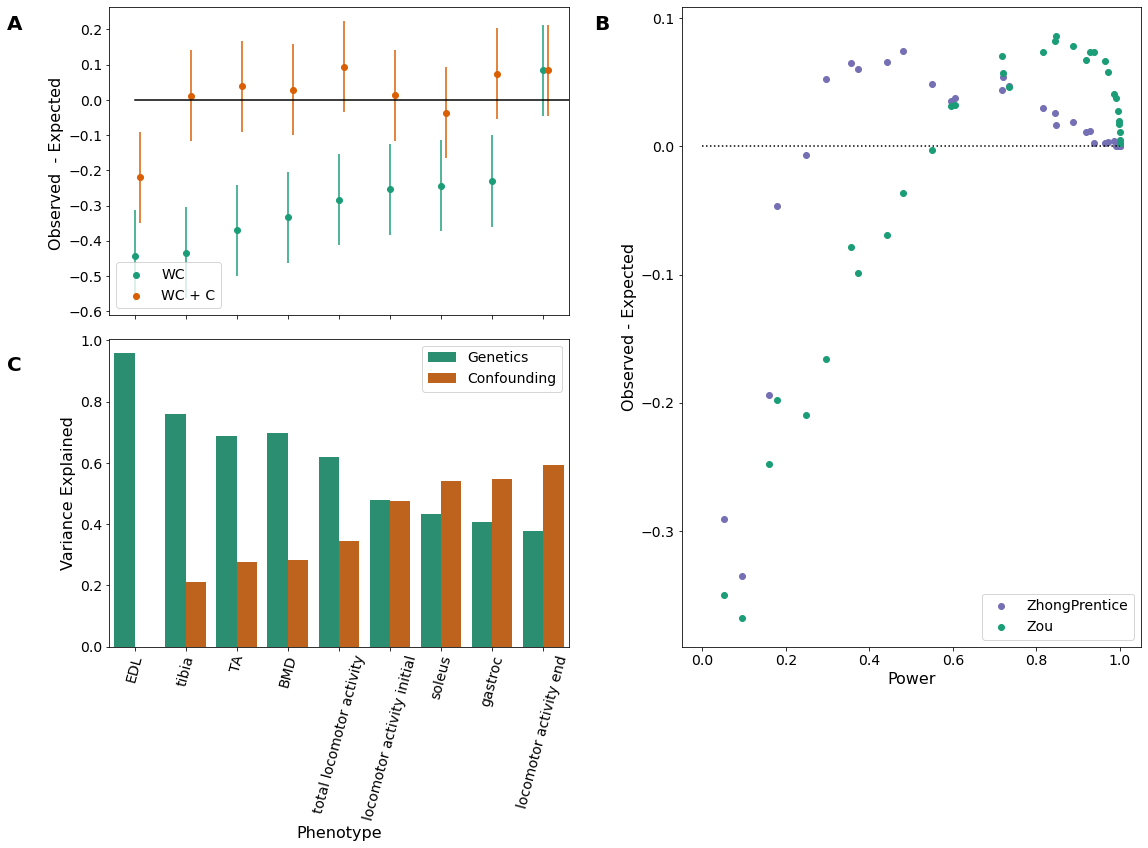

In [90]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[:, 1])

## Define plot space
#fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax1.text(-2.5, .2, "A", size=20, weight='bold')
ax1.scatter(np.array(range(ox_uc_pheno.shape[0])), ox_uc_pheno["diff_pred"], c="#1b9e77", label = "WC")
ax1.errorbar(np.array(range(ox_uc_pheno.shape[0])), ox_uc_pheno["diff_pred"], yerr=2*sd, ls='none', c="#1b9e77")
ax1.scatter(np.array(range(ox_uc_pheno.shape[0]))+.1, ox_uc_pheno["diff_pred_wcc"], c = "#d95f02", label = "WC + C")
ax1.errorbar(np.array(range(ox_uc_pheno.shape[0]))+.1, ox_uc_pheno["diff_pred_wcc"], yerr=2*sd, ls='none', c = "#d95f02")
#ax.set_xlabel("Phenotype")
ax1.set_ylabel("Observed  - Expected ")
ax1.plot([0, ox_uc_pheno.shape[0]], [0, 0], c = "black")
ax1.set_xticks(range(ox_uc_pheno.shape[0]))
ax1.set_xticklabels([])
#ax1.set_xticklabels([" " for i in range(ox_uc_pheno.shape[0])],  rotation=45)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend(loc="lower left")

ax2.text(-2.5, .9, "C", size=20, weight='bold')
sns.barplot(x="phenotype2", y="var_exp", hue="Variance Explained", data=plot_data, hue_order=["Genetics", "Confounding"], palette=["#1b9e77", "#d95f02"], ax = ax2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=labels)
ax.set_xticks(range(ox_uc_pheno.shape[0]))
ax2.set_xticklabels(labels=rep["phenotype2"], rotation=75)
ax2.set_xlabel("Phenotype")
ax2.set_ylabel("Variance Explained")

ax1.text(9, .2, "B", size=20, weight='bold')
#ax3.text(-0.4, .7, string.ascii_uppercase[1], transform=ax.transAxes, size=20, weight='bold')
ax3.scatter("power", "diff", data=out, label="ZhongPrentice", c="#7570b3")
ax3.scatter("power", "diff", data=data, label="Zou", c="#1b9e77")
ax3.legend(loc="lower right")
ax3.plot([0, 1], [0, 0], color="black", linestyle="dotted")
ax3.set_xlabel("Power")
ax3.set_ylabel("Observed - Expected")
plt.tight_layout()
plt.savefig("/u/home/j/jzou1115/project-zarlab/CFW/replication_pruned/output_phenotypes_pooled_2/Figure7.png")
